<a href="https://colab.research.google.com/github/joshuamwalker/Roeslein/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

class generic_instrument:
  '''
  Input Arguments:
    ActualValue: Actual value of the parameter the instrument is measuring
    PctError: Percent error of the instrument (percentage of actual value)
    ErrorType: Normal or Uniform
    Ni: Number of iterations to generate (typ. 1e6)
    EngUnits: User-defined string, used in plotting
  '''
  def __init__(self, ActualValue, PctError, ErrorType, Ni, EngUnits=''):
    self.ActualValue = ActualValue
    self.PctError = PctError
    self.ErrorType = ErrorType
    self.EngUnits = EngUnits
    if self.ErrorType == 'Normal':
      # For normal distribution, PctError is taken as the 1-sigma value
      self.StdDev = self.ActualValue * self.PctError / 100
      self.MeasuredValues = np.random.normal(self.ActualValue, self.StdDev, int(Ni)) # Normal error distribution
      self.MinMeas = self.ActualValue - self.StdDev # Not used for computation but provided for assistance when plotting
      self.MaxMeas = self.ActualValue + self.StdDev # Not used for computation but provided for assistance when plotting
    elif self.ErrorType == 'Uniform':
      # For uniform distribution, PctError is taken as the min/max distance from the actual value value
      self.MinMeas = self.ActualValue * (1 - self.PctError / 100) # Minimum measurement
      self.MaxMeas = self.ActualValue * (1 + self.PctError / 100) # Maximum measurement
      self.MeasuredValues = np.random.uniform(self.MinMeas, self.MaxMeas, int(Ni)) # Uniform error distribution
    else:
      print('Error: Error distribution type not specified')
      return 0
    self.StdDev = np.std(self.MeasuredValues) # Not used for computation but provided for assistance when plotting
    if self.ActualValue != 0:
      self.RelStdDev = self.StdDev / self.ActualValue # Not used for computation but provided for assistance when plotting
    else:
      self.RelStdDev = 0

class ultrasonic_flowmeter():
  def __init__(self, X_config, X_mixture, PctError, ErrorType, Ni, PrintOutput, StreamName):
    '''
    Error and ErrorType should be that of the raw speed of sound measurement
    '''
    if 1: # Molecular weights and adiabatic indices of components
      M_H = 1.008
      M_C = 12.011
      M_N = 14.007
      M_O = 15.999
      M_CH4 = M_C + M_H * 4
      M_CO2 = M_C + M_O * 2
      M_O2 = M_O * 2
      M_N2 = M_N * 2
      M_H2O = M_O + M_H * 2
      gamma_CH4 = 1.32
      gamma_CO2 = 1.28
      gamma_O2 = 1.40
      gamma_N2 = 1.40
      gamma_H2O = 1.33
    M_arr = np.array([M_CH4, M_CO2, M_O2, M_N2, M_H2O])
    gamma_arr = np.array([gamma_CH4, gamma_CO2, gamma_O2, gamma_N2, gamma_H2O])
    R = 8.314 # J/mol/K
    T = 301.4 # K
    # Calculate internal device configuration parameters
    self.X_config = np.array(X_config) / np.sum(X_config) * 100 # Normalize calibration mixture composition
    self.M_other_config = np.dot(M_arr[1:], self.X_config[1:] / np.sum(self.X_config[1:])) # Calculate molar mass of non-CH4 compounds
    self.gamma_other_config = np.dot(gamma_arr[1:], self.X_config[1:] / np.sum(self.X_config[1:]))
    # Calculate actual values of mixture
    self.X_mixture = np.array(X_mixture) / np.sum(X_mixture) * 100 # Normalize mixture composition
    self.ActualValue = self.X_mixture[0]
    self.M_mixture = np.dot(M_arr, self.X_mixture / 100) # Calculate molar mass of entire mixture
    self.gamma = np.dot(gamma_arr, self.X_mixture / 100) # Calculate gamma (adiabatic index) of entire mixture
    self.c_mixture = np.sqrt(self.gamma * R * T * 1000 / self.M_mixture)
    # Calculate flowmeter measured speed of sound, accounting for instrument error
    self.c_measured = generic_instrument(self.c_mixture, PctError, ErrorType, Ni, '%mol').MeasuredValues # Measured molar mass of entire mixture
    # Replicate flowmeter internal calculation
    self.X_meas_numerator = self.gamma_other_config * R * T * 1000 / self.c_measured**2 - self.M_other_config
    self.X_meas_denominator = (M_CH4 - self.M_other_config) - (gamma_CH4 - self.gamma_other_config) * (R * T * 1000 / self.c_measured**2)
    self.MeasuredValues = self.X_meas_numerator / self.X_meas_denominator * 100
    self.Mean_meas = np.mean(self.MeasuredValues)
    self.AbsErr = self.Mean_meas - self.X_mixture[0]
    self.RelErr = self.AbsErr / self.X_mixture[0] * 100
    self.StdDev = np.std(self.MeasuredValues)
    self.RelStdDev = self.StdDev / self.X_mixture[0] * 100
    if PrintOutput:
      print(StreamName)
      print('     Actual CH4 = %1.3f %%mol' % self.ActualValue)
      print('      M_mixture = %1.3f g/mol' % self.M_mixture)
      print('   Measured CH4 = %1.3f %%mol' % self.Mean_meas)
      print(' Absolute Error = %1.3f %%mol' % self.AbsErr)
      print(' Relative Error = %1.3f %%' % self.RelErr)
      print('      AbsStdDev = %1.3f %%mol' % self.StdDev)
      print('      RelStdDev = %1.3f %%' % self.RelStdDev)
      print()

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reuse from earlier
def plot_histogram_with_cdf(E, title="Histogram with CDF Overlay", ax=None):
  sorted_E = np.sort(E)
  cdf = np.arange(1, len(sorted_E) + 1) / len(sorted_E)
  sorted_E = np.insert(sorted_E, 0, sorted_E[0])
  cdf = np.insert(cdf, 0, 0)
  cdf_at_0 = np.sum(E <= 0) / len(E)

  if ax is None:
    fig, ax1 = plt.subplots(figsize=(6, 4))
  else:
    ax1 = ax

  sns.histplot(E, bins=50, stat='density', ax=ax1,
              color='steelblue', alpha=0.7, edgecolor='none', zorder=4)

  ax1.set_yticks([])      # Remove y-axis ticks
  ax1.set_ylabel("")      # Remove y-axis label
  ax1.set_yticklabels([]) # Remove tick labels
  ax1.grid(False)         # Remove gridlines

  ax2 = ax1.twinx()
  ax2.plot(sorted_E, cdf, color='darkred', linewidth=2, label='CDF', zorder=5)
  ax2.set_ylabel('Cumulative Probability')
  ax2.set_ylim(0, 1)


  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  # ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

  ax2.annotate(f'CDF(0) = {cdf_at_0:.1%}', xy=(0, cdf_at_0), xytext=(0.05, cdf_at_0 + 0.1),
               textcoords='data', arrowprops=dict(arrowstyle='->', color='gray'),
               fontsize=10, color='black', zorder=6)

  ax1.set_title(title)

  if ax is None:
    plt.tight_layout()
    plt.show()

# Generic plot grid function
def plot_simulation_grid(sim_outputs, titles=None):
  n = len(sim_outputs)
  cols = min(3, n)
  rows = int(np.ceil(n / cols))

  fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
  axes = np.array(axes).reshape(-1)

  for i, E in enumerate(sim_outputs):
    title = titles[i] if titles else f"Sim {i+1}"
    plot_histogram_with_cdf(E, title=title, ax=axes[i])

  # Hide any unused axes
  for j in range(i + 1, len(axes)):
    axes[j].axis('off')

  plt.tight_layout()
  plt.show()

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_histogram_with_shading(E, title="Histogram with Shaded Negative Region", ax=None):
  E = np.array(E)
  pct_below_0 = np.sum(E < 0) / len(E)

  if ax is None:
    fig, ax = plt.subplots(figsize=(6, 4))

  # Define bins so that 0 is on an edge
  num_bins = 50
  min_E, max_E = E.min(), E.max()
  bin_edges = np.linspace(min_E, max_E, num_bins + 1)

  # Adjust to ensure 0 is included as a bin edge
  if 0 not in bin_edges:
    bin_edges = np.unique(np.sort(np.append(bin_edges, 0)))

  # Plot histogram with custom bins
  bars = sns.histplot(E, bins=bin_edges, stat='density', ax=ax,
                      color='steelblue', alpha=0.7, edgecolor='none', zorder=4)

  # Shade bars with left edge < 0
  for patch in bars.patches:
    if patch.get_x() < 0:
      patch.set_facecolor('crimson')
      patch.set_alpha(0.7)

  # Format plot
  ax.set_xlabel("Methane Imbalance [SCFM_CH4]")
  ax.set_xlim([-10,10])
  ax.set_yticks([])
  ax.set_ylabel("")
  ax.set_yticklabels([])
  ax.grid(False)
  ax.set_title(title)

  # Annotation at top-left
  ax.annotate(f'{pct_below_0:.1%} ≤ 0',
              xy=(0.02, 0.95), xycoords='axes fraction',
              ha='left', va='top', fontsize=10,
              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.8))

  if ax is None:
    plt.tight_layout()
    plt.show()

def plot_simulation_grid2(sim_outputs, titles=None):
  n = len(sim_outputs)
  cols = min(3, n)
  rows = int(np.ceil(n / cols))

  fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
  axes = np.array(axes).reshape(-1)

  for i, E in enumerate(sim_outputs):
    title = titles[i] if titles else f"Sim {i+1}"
    plot_histogram_with_shading(E, title=title, ax=axes[i])

  # Hide any unused axes
  for j in range(i + 1, len(axes)):
    axes[j].axis('off')

  plt.tight_layout()
  plt.show()


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_methane_overlay_histograms(methane_in, methane_out, title="Methane In vs. Out"):
  methane_in = np.array(methane_in)
  methane_out = np.array(methane_out)

  # Combine for common bins and make 0 a bin edge
  combined = np.concatenate([methane_in, methane_out])
  num_bins = 50
  min_val, max_val = combined.min(), combined.max()
  bin_edges = np.linspace(min_val, max_val, num_bins + 1)

  fig, ax = plt.subplots(figsize=(6, 4))

  sns.histplot(methane_in, stat='density', ax=ax,
               color='dodgerblue', alpha=0.5, edgecolor='none', label='Methane In', zorder=3)

  sns.histplot(methane_out, stat='density', ax=ax,
               color='orange', alpha=0.5, edgecolor='none', label='Methane Out', zorder=4)

  ax.set_xlim([0,65])
  ax.set_title(title)
  ax.set_xlabel("Flowrate [SCFM]")
  ax.set_ylabel("")  # Optional: suppress y-axis
  ax.set_yticks([])
  ax.set_yticklabels([])
  ax.grid(False)
  ax.legend(loc='upper right')

  plt.tight_layout()
  plt.show()


[96. 97. 98. 99.]
[0.06  0.045 0.03  0.015]


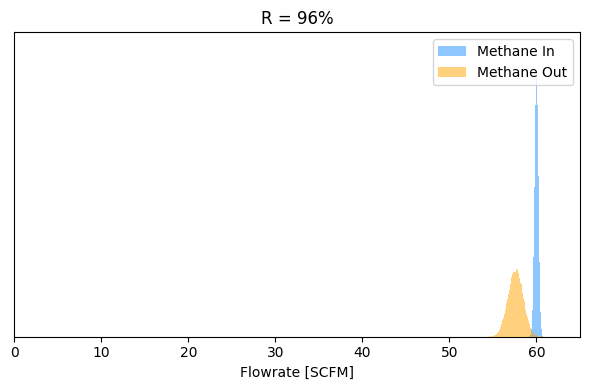

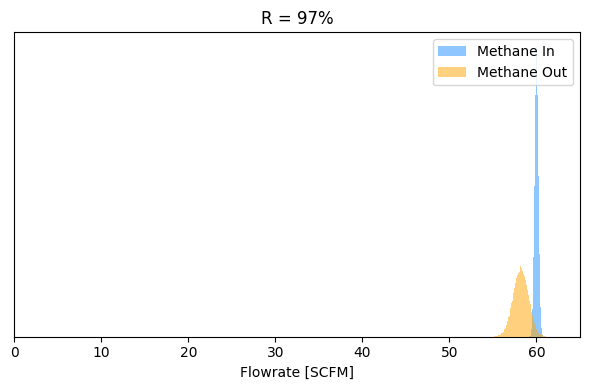

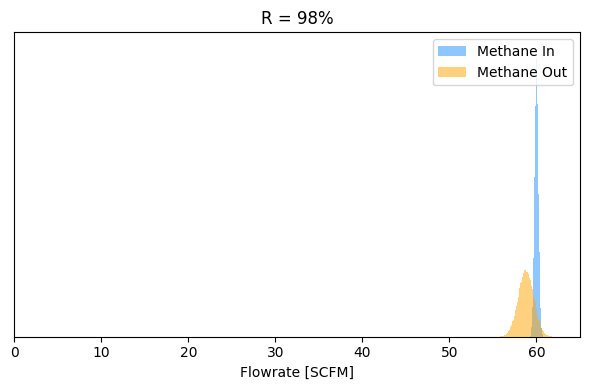

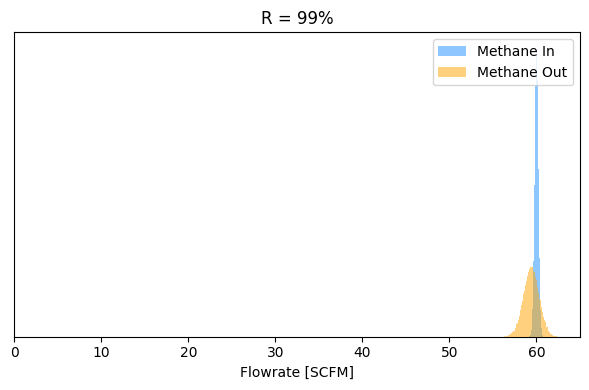

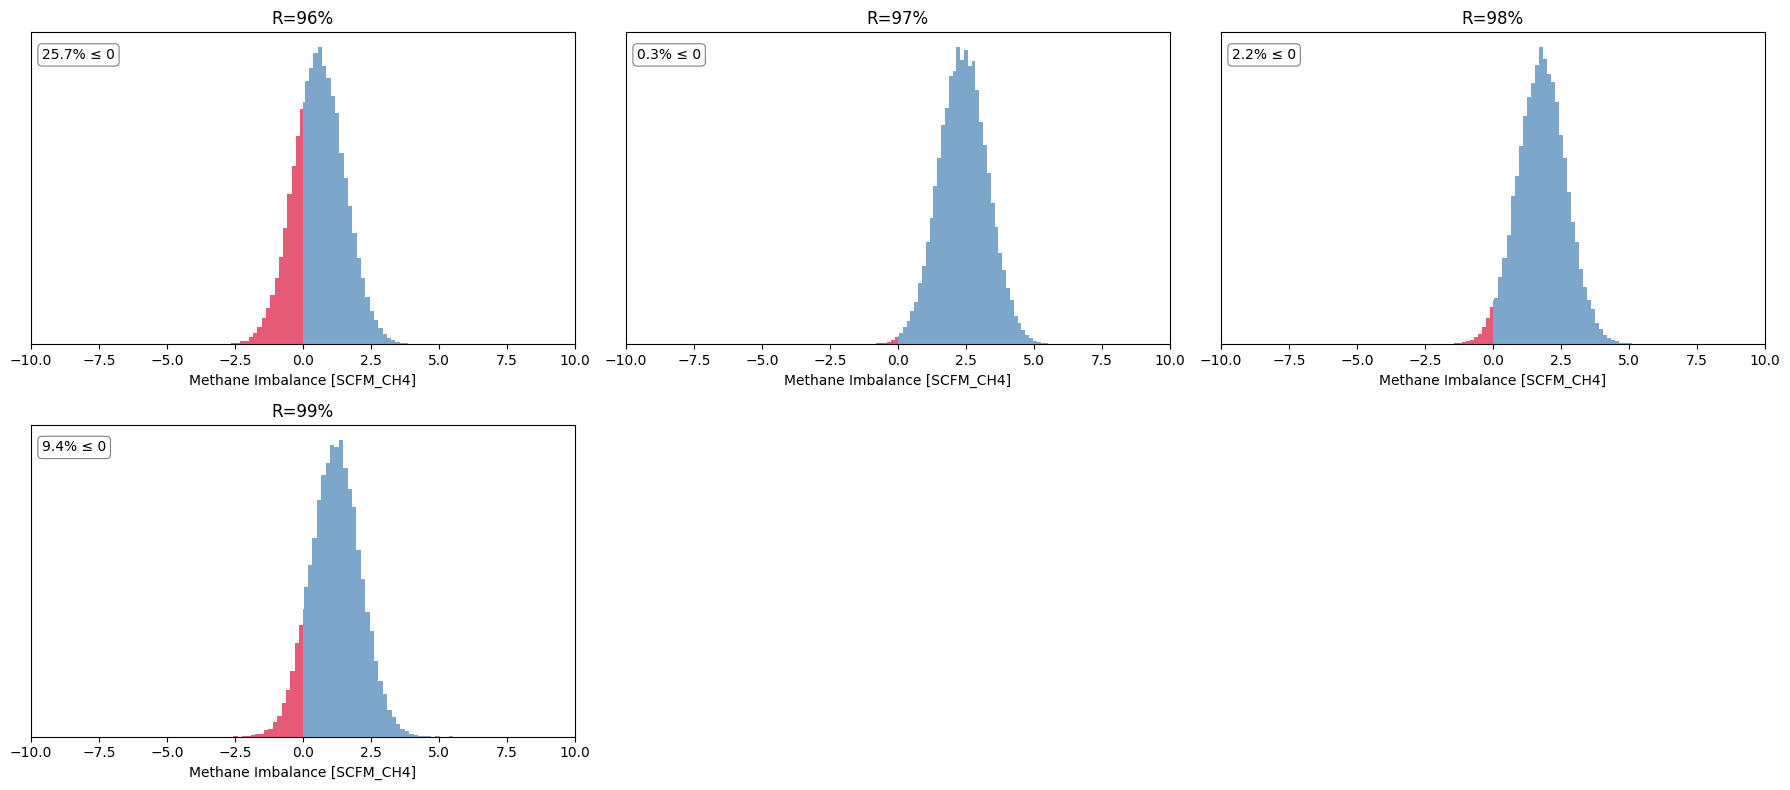

In [45]:
# Given simulation conditions
n = 5e4
F_F = 100
X_F = 60
F_P = 60
Rs = np.array([96, 97, 98, 99])  # Recovery percentages
X_Ps = F_F * X_F / 100 * Rs / 100 / F_P * 100
print(X_Ps)
F_Ts = F_F - F_P
X_Ts = (F_F * X_F / 100 - F_P * X_Ps / 100) / F_Ts
print(X_Ts)

sim_outputs = []
titles = []

# Run simulations
for R, X_P in zip(Rs, X_Ps):
  FT_3131 = generic_instrument(F_F, 0.72 / 2, 'Normal', n, EngUnits='SCFM')
  AT_3131_e0 = generic_instrument(0, 1.00 / 2, 'Normal', n, EngUnits='mol%')
  AT_3131_e1 = generic_instrument(0, 1.20 / 2, 'Normal', n, EngUnits='mol%')
  FT_3732 = generic_instrument(F_P, 0.25 / 2, 'Normal', n, EngUnits='SCFM')
  AT_3753 = generic_instrument(X_P, 3.00 / 2, 'Normal', n, EngUnits='mol%')

  # E = FT_3131.MeasuredValues * (X_F + AT_3131_e0.MeasuredValues + AT_3131_e1.MeasuredValues) / 100 - FT_3732.MeasuredValues * AT_3753.MeasuredValues / 100

  sim_outputs.append(E)
  titles.append(f'R={R}%')

  CH4_F = FT_3131.MeasuredValues * (X_F + AT_3131_e0.MeasuredValues + AT_3131_e1.MeasuredValues) / 100
  CH4_P = FT_3732.MeasuredValues * AT_3753.MeasuredValues / 100
  E = CH4_F - CH4_P
  # plot_histogram_with_shading(E, title=f'R={R}%')

  title = f"R = {R}%"
  plot_methane_overlay_histograms(CH4_F, CH4_P, title=title)

# Plot the results
plot_simulation_grid2(sim_outputs, titles)